In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install torchmetrics --quiet

!pip install basicsr
!python /content/drive/MyDrive/ReBotNET/rebot-net-main/dataset_loader.py


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 25.9 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=8b14474484e95d4d6d21d0594e84bd2f24b6520e9b4c6ccabe76465b884f9c15
  Stored in directory: /root/.cache/pip/wheels/9a/e3/e4/58f29bfabb622dd40b6d9839318ce5bf092062b81ca3aa19ea
Successfully built basicsr
Traceback (most recent call last):
  File "/content/drive/MyDrive/ReBotNET/rebot-net-main/dataset_loader.py", line 7, in <module>
    import utils.utils_video as ut

In [6]:
import sys
import torch
import copy
from torch.utils.data import DataLoader,ConcatDataset
sys.path.append('/content/drive/MyDrive/ReBotNET/rebot-net-main')
from dataset_loader_new_1 import PortraitVideoRecurrentTrainDataset
#Define paths
DRIVE_GT_PATH = "/content/drive/MyDrive/ReBotNET/Data_set/Vimeo_Test_GT"
OUTPUT_META_FILE = f"{DRIVE_GT_PATH}/meta_info.txt"

opt = {
    #FIXED PARAMETERS
    'dataroot_gt': DRIVE_GT_PATH,
    'dataroot_lq': DRIVE_GT_PATH,
    'meta_info_file': OUTPUT_META_FILE,
    'io_backend': {'type': 'disk'},

    'num_frame': 2,
    'gt_size': 64,
    'scale': 4,

    # CONFIGURATION
    'use_hflip': True,
    'use_rot': True,
    'test_mode': False,
    'kernel_list': ['iso', 'aniso', 'generalized_iso', 'generalized_aniso', 'plateau_iso', 'plateau_aniso'],
    'kernel_prob': [0.1, 0.1, 0.2, 0.2, 0.2, 0.2],
    'random_reverse': True,
}

print("Initializing dataset...")
try:
  dataset_list = [] # Initialize 'dataset' as an empty list

  for i in range(3):
    # Create a new instance of the dataset class
    dataset_instance = PortraitVideoRecurrentTrainDataset(copy.deepcopy(opt))
    dataset_list.append(dataset_instance)
    print(f"Total sequences for training: {len(dataset_instance)}")
except Exception as e:
    print(f"Error during batch loading: {e}")

# Concatenate individual dataset objects into a single PyTorch Dataset
dataset = ConcatDataset(dataset_list)

print(f"Total number of combined samples: {len(dataset)}")

Initializing dataset...
Temporal augmentation interval list: [1]; random reverse is True.
Total sequences for training: 54768
Temporal augmentation interval list: [1]; random reverse is True.
Total sequences for training: 54768
Temporal augmentation interval list: [1]; random reverse is True.
Total sequences for training: 54768
Total number of combined samples: 164304


In [7]:
from torch.utils.data import random_split, DataLoader

# Define split ratio
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} samples, Test: {len(test_dataset)} samples")


Train: 131443 samples, Test: 32861 samples


In [4]:
import sys
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchmetrics
from time import time

# PATH SETUP
sys.path.append('/content/drive/MyDrive/ReBotNET/rebot-net-main')
from models.archs import rebotnet as net  # Import model

# CONFIGURATION
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device in use: {device}")

pa_frames = 2
img_size = [2, 384, 384]  # temporal dim, H, W
batch_size = 4
num_epochs = 1


# INITIALIZE MODEL
model = net(
    upscale=1, img_size=img_size, window_size=[6,8,8],
    depths=[3,3,3,3], indep_reconsts=[9,10],
    embed_dims=[64,80,108,116],
    num_heads=[6]*13, pa_frames=pa_frames, deformable_groups=12,
    mlp_dim=256, bottle_depth=4, bottle_dim=116,
    dropout=0.1, patch_size=1
).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# METRICS (PSNR, SSIM)
psnr_metric = torchmetrics.image.PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# TRAINING LOOP
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_psnr = 0
    epoch_ssim = 0

    # tqdm shows batch number and ETA
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for batch_idx, batch in enumerate(loop, 1):
        lq = batch['L'].to(device)  # (b, t, c, h, w)
        hr = batch['H'].to(device)
        b, t, c, h, w = lq.shape

        optimizer.zero_grad()
        loss = 0
        batch_psnr = 0
        batch_ssim = 0

        prev_pred = lq[:, 0]  # use first frame as prev prediction
        for i in range(t):
            current_frame = lq[:, i]
            input_frame = torch.stack([prev_pred, current_frame], dim=1)  # (b, 2, c, h, w)
            output = model(input_frame)
            gt = hr[:, i]

            # Compute loss + metrics
            loss_i = criterion(output, gt)
            psnr_i = psnr_metric(output, gt)
            ssim_i = ssim_metric(output, gt)

            loss += loss_i
            batch_psnr += psnr_i.item()
            batch_ssim += ssim_i.item()

            prev_pred = output.detach()

        loss.backward()
        optimizer.step()

        # Update epoch stats
        epoch_loss += loss.item() / t
        epoch_psnr += batch_psnr / t
        epoch_ssim += batch_ssim / t

        # Update tqdm description: batch number and ETA
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}]")

    # Print metrics only after the epoch
    print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"  Avg Loss: {epoch_loss/len(train_loader):.6f}")
    print(f"  Avg PSNR: {epoch_psnr/len(train_loader):.2f}")
    print(f"  Avg SSIM: {epoch_ssim/len(train_loader):.4f}")

print("Files moved successfully. Temporary disk cleaned up.")

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Device in use: cuda



Epoch [1/1] Summary:
  Avg Loss: 0.013268
  Avg PSNR: 32.50
  Avg SSIM: 0.9180
Files moved successfully. Temporary disk cleaned up.


In [5]:
final_model_path = "/content/drive/MyDrive/ReBotNET/rebotnet_final_large.pth"
torch.save(model.state_dict(), final_model_path)
print(f"\nTraining complete. Final model saved at: {final_model_path}")


Training complete. Final model saved at: /content/drive/MyDrive/ReBotNET/rebotnet_final_large.pth


In [9]:
import sys
import os
import time
import torch
from tqdm import tqdm
import torchmetrics

# PATH SETUP
sys.path.append('/content/drive/MyDrive/ReBotNET/rebot-net-main')
from models.archs import rebotnet as net  # Import model

# CONFIG
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")

pa_frames = 2
img_size = [2, 384, 384]


# Rebot M
model = net(
    upscale=1, img_size=img_size, window_size=[6,8,8],
    depths=[3,3,3,3], indep_reconsts=[9,10],
    embed_dims=[64,80,108,116],
    num_heads=[6]*13, pa_frames=pa_frames, deformable_groups=12,
    mlp_dim=256, bottle_depth=4, bottle_dim=116,
    dropout=0.1, patch_size=1
).to(device)

# LOAD CHECKPOINT
ckpt_path = "/content/drive/MyDrive/ReBotNET/rebotnet_final_large.pth"
assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

# METRICS (PSNR,SSIM)
psnr_metric = torchmetrics.image.PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# EVALUATION
total_psnr = 0.0
total_ssim = 0.0
total_frames = 0
total_latency = 0.0

with torch.no_grad():
    progress = tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluating", unit="batch")

    for batch_idx, batch in progress:
        lq = batch['L'].to(device)  # (b, t, c, h, w)
        hr = batch['H'].to(device)
        b, t, c, h, w = lq.shape

        batch_psnr = 0.0
        batch_ssim = 0.0
        frame_count = 0

        prev_pred = lq[:, 0]  # initial frame for each video in batch
        for i in range(t):
            current_frame = lq[:, i]
            input_frame = torch.stack([prev_pred, current_frame], dim=1)  # (b, 2, c, h, w)

            start_time = time.time()
            output = model(input_frame)
            latency = time.time() - start_time
            total_latency += latency

            gt = hr[:, i]
            psnr_i = psnr_metric(output, gt)
            ssim_i = ssim_metric(output, gt)

            batch_psnr += psnr_i.item() * b
            batch_ssim += ssim_i.item() * b
            frame_count += b
            total_frames += b

            prev_pred = output.detach()

        # Average for this batch
        batch_psnr /= frame_count
        batch_ssim /= frame_count
        total_psnr += batch_psnr
        total_ssim += batch_ssim

        progress.set_postfix({
            "Batch_PSNR": f"{batch_psnr:.2f}",
            "Batch_SSIM": f"{batch_ssim:.4f}"
        })

# FINAL RESULTS
avg_psnr = total_psnr / len(test_loader)
avg_ssim = total_ssim / len(test_loader)
avg_latency = (total_latency / total_frames) * 1000  # ms per frame


print(f"Average PSNR : {avg_psnr:.2f} dB")
print(f"Average SSIM : {avg_ssim:.4f}")
print(f"Average Latency per Frame : {avg_latency:.2f} ms")


Device in use: cuda


Evaluating: 100%|██████████| 8216/8216 [47:14<00:00,  2.90batch/s, Batch_PSNR=39.40, Batch_SSIM=0.9791]

Average PSNR : 33.39 dB
Average SSIM : 0.9295
Average Latency per Frame : 7.51 ms


Loaded weights Succesfully
Enhanced 49 frames


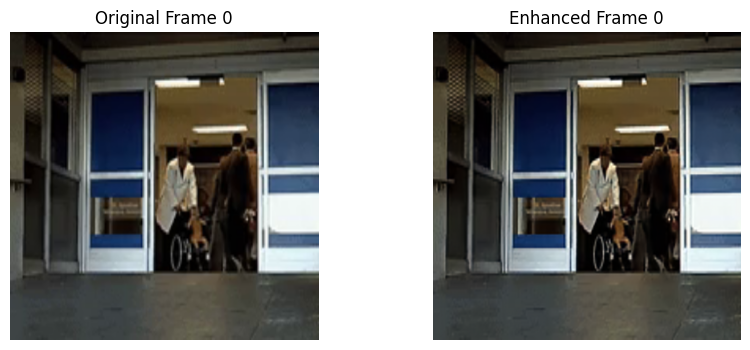

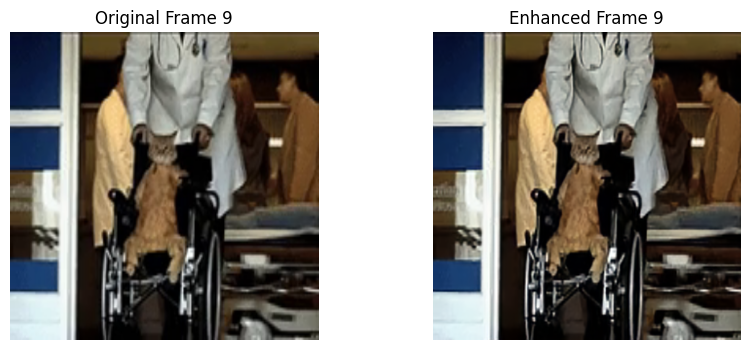

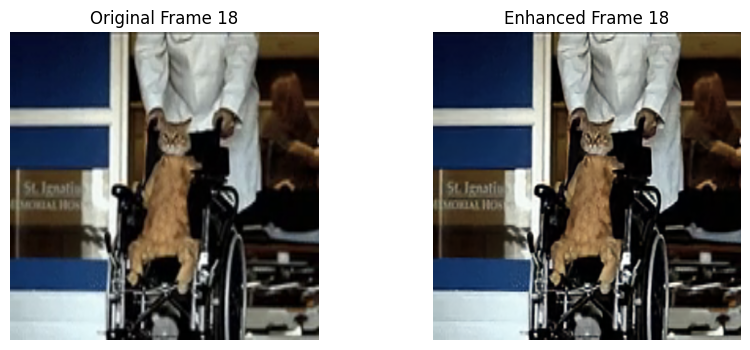

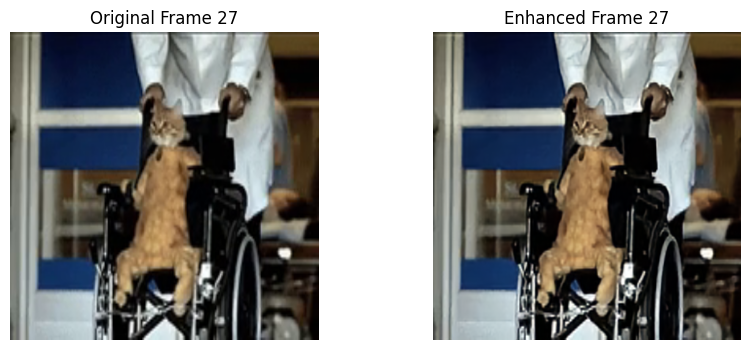

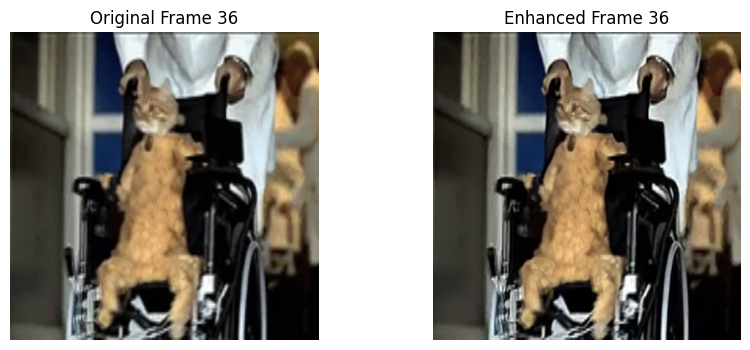

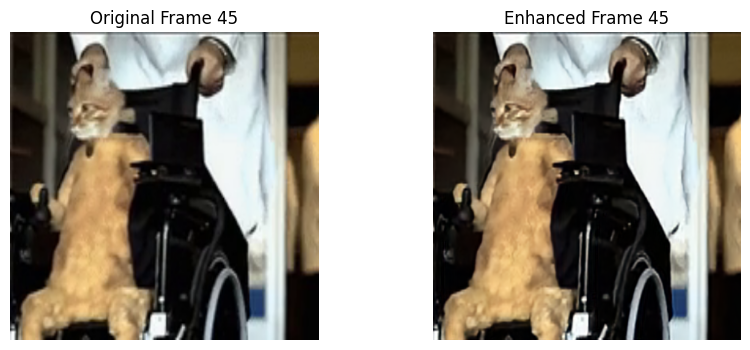

In [18]:
import cv2
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
import os

# PATH
sys.path.append('/content/drive/MyDrive/ReBotNET/rebot-net-main/models')
from archs import rebotnet as net

# CONFIGURATION
video_path = "/content/drive/MyDrive/Sample/in.mp4"
weights_path = "/content/drive/MyDrive/ReBotNET/rebotnet_final_large.pth"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = (384, 384)   # (W, H)
pa_frames = 2
model_variant = "rebot_M"

# MODEL INITIALIZATION
def load_model(model_variant):
    if model_variant == "rebot_M":
        return net(upscale=1, img_size=[2,384,384], window_size=[6,8,8],
                   depths=[3,3,3,3], indep_reconsts=[9,10],
                   embed_dims=[64,80,108,116], num_heads=[6]*13,
                   pa_frames=pa_frames, deformable_groups=12,
                   mlp_dim=256, bottle_depth=4, bottle_dim=116,
                   dropout=0.1, patch_size=1)
    else:
        raise ValueError("Only rebot_M is configured here.")

model = load_model(model_variant).to(device)

# Load trained weights
if os.path.exists(weights_path):
    checkpoint = torch.load(weights_path, map_location=device)
    if "params" in checkpoint:
        checkpoint = checkpoint["params"]
    model.load_state_dict(checkpoint)
    print(f"Loaded weights Succesfully")
else:
    print(f"Warning: No weights found")

model.eval()
# LOAD VIDEO
cap = cv2.VideoCapture(video_path)
frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size)
    frames.append(frame)

cap.release()

frames = np.stack(frames, axis=0)  # [T, H, W, C]
frames = frames.astype(np.float32) / 255.0
frames = torch.from_numpy(frames).permute(0, 3, 1, 2).unsqueeze(0).to(device)  #[1, T, C, H, W]
T = frames.shape[1]

# ENHANCE FRAMES
enhanced_frames = []

with torch.no_grad():
    first_frame = frames[:, 0]
    first_input = torch.stack([first_frame, first_frame], dim=1)
    first_output = model(first_input)
    prev_pred = first_output
    enhanced_frames.append(first_output)

    for i in range(1, T):
        curr_frame = frames[:, i]
        clip = torch.stack([prev_pred, curr_frame], dim=1)
        output = model(clip)
        prev_pred = output
        enhanced_frames.append(output)

print(f"Enhanced {len(enhanced_frames)} frames")

# PLOT ORIGINAL VS ENHANCED
for i in range(0, len(enhanced_frames), max(1, len(enhanced_frames)//5)):
    orig = frames[0, i].permute(1, 2, 0).cpu().numpy()
    enh = enhanced_frames[i].squeeze(0).permute(1, 2, 0).cpu().numpy()

    orig = np.clip(orig, 0, 1)
    enh = np.clip(enh, 0, 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig)
    plt.title(f"Original Frame {i}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(enh)
    plt.title(f"Enhanced Frame {i}")
    plt.axis("off")

    plt.show()
